## ChEMBL bioactivity score

For the prioritisation, of scaffolds, one metric is bioactivity proclivity of the scaffold.
Here a simple metric of scaffolds following https://pubs.acs.org/doi/10.1021/acs.jcim.3c01096 is done.

> HAC ≤ 50, separated them into 560 230 actives (IC50 or EC50 ≤ 10 μM, ChEMBL_actives)

To make life even easier I am using Papyrus.

In [10]:
from papyrus_scripts.download import download_papyrus

download_papyrus(version='latest', structures=True, descriptors=['mold2', 'unirep'],
                 outdir='/tmp/papyrus')

Latest version: 05.6
########## DISCLAIMER ##########
You are downloading the high-quality Papyrus++ dataset.
Should you want to access the entire, though of lower quality, Papyrus dataset,
look into additional switches of this command.
################################
Number of files to be downloaded: 6
Total size: 2.17GB


In [1]:
import pandas as pd
from papyrus_scripts.reader import read_papyrus, read_protein_set

sample_data: pd.io.parsers.readers.TextFileReader = read_papyrus(is3d=False, chunksize=10000, source_path='/tmp/papyrus')

In [9]:
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover
from typing import Sequence
import gzip, contextlib
from collections import defaultdict
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
import contextlib

_active = defaultdict(int)
_inactive = defaultdict(int)
_lowest = defaultdict(int)
_examplars = {}
#for smiles in df.loc[df.pchembl_value_Median > 5.].SMILES:
sample_data = read_papyrus(is3d=False, chunksize=10000, source_path='/tmp/papyrus')
for chunk in sample_data:
    for i, row in chunk.iterrows():
        with contextlib.suppress(Exception):
            mol: Chem.Mol = Chem.MolFromSmiles(row.SMILES)
            scaffold = MurckoScaffold.GetScaffoldForMol(mol)
            scaffold_smiles = Chem.MolToSmiles(scaffold)
            if row.pchembl_value_Median > 5.:
                _active[scaffold_smiles] += 1
            else:
                _inactive[scaffold_smiles] += 1
            # fill example w/ chembl id
            if _lowest[scaffold_smiles] < row.pchembl_value_Median:
                _examplars[scaffold_smiles] = row.source
                _lowest[scaffold_smiles] = row.pchembl_value_Median


scaffolds = pd.concat([pd.DataFrame([{'SMILES': smiles, 'active_count': count} for smiles, count in _active.items()]).set_index('SMILES'),
                       pd.DataFrame([{'SMILES': smiles, 'inactive_count': count} for smiles, count in _inactive.items()]).set_index('SMILES')
                      ],
                      axis=1
                       ).fillna(0).astype(int)
scaffolds['example'] = _examplars
del _active
del _inactive
del _lowest
del _examplars
scaffolds['raw_ratio'] = scaffolds.active_count  / scaffolds.inactive_count
alpha = (scaffolds.active_count + scaffolds.inactive_count).mean()
scaffolds['smoothed_ratio'] = (scaffolds.active_count + alpha) / (scaffolds.inactive_count + 2 * alpha)
scaffolds['N_HA'] = scaffolds.index.to_series().apply(Chem.MolFromSmiles).apply(Chem.Mol.GetNumHeavyAtoms)
scaffolds['Total'] = scaffolds.active_count	+ scaffolds.inactive_count
scaffolds = scaffolds.sort_values('ratio', ascending=False).copy()
scaffolds.to_csv('ChEMBL-active-scaffolds.csv')

[11:46:57] Explicit valence for atom # 0 C greater than permitted


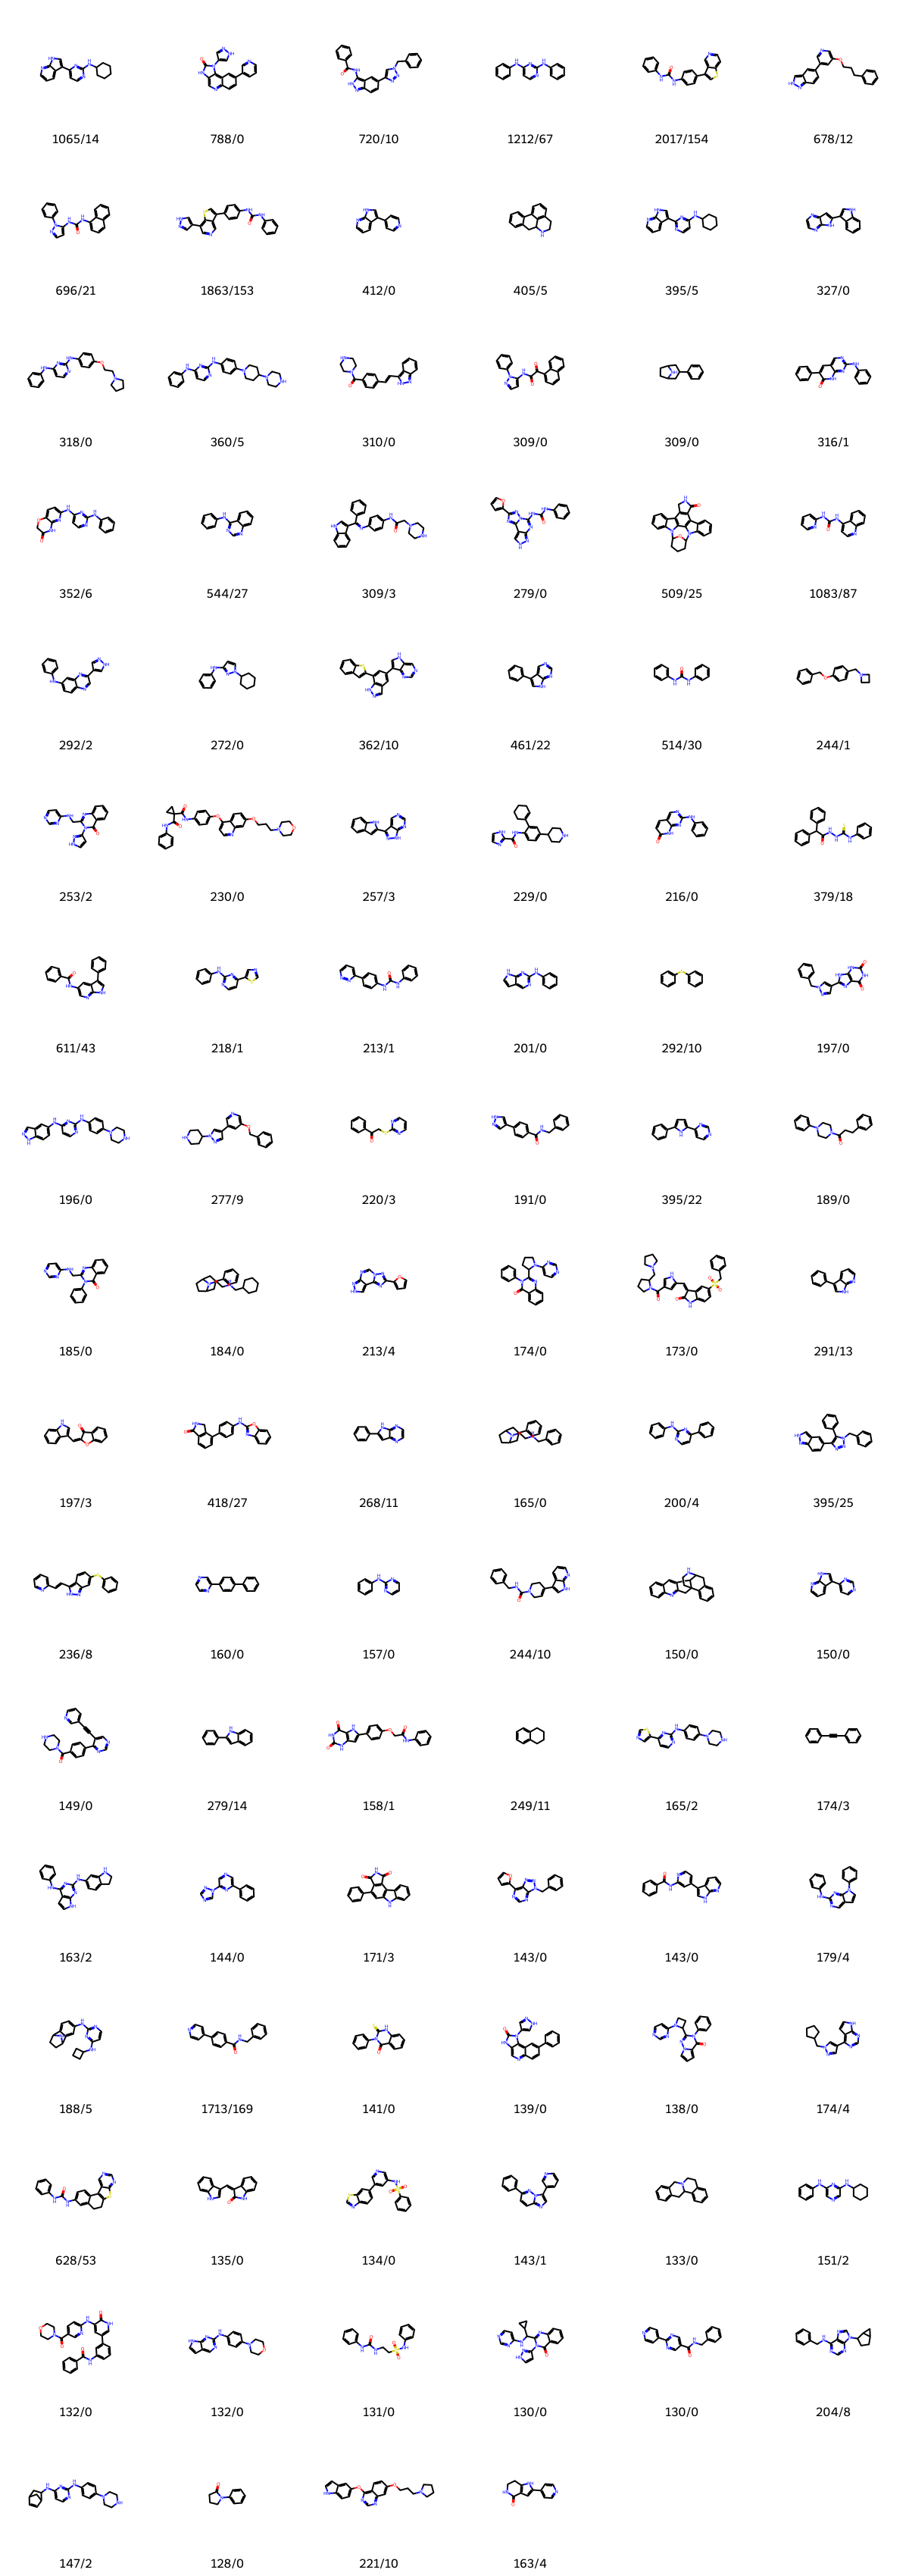

In [18]:
from rdkit.Chem import Draw

Draw.MolsToGridImage(scaffolds.iloc[:100].index.to_series().apply(Chem.MolFromSmiles).to_list(),
                     legends=scaffolds.iloc[:100].apply(lambda row: f'{row.active_count:.0f}/{row.inactive_count:.0f}', axis=1).to_list(),
                     molsPerRow=6, maxMols=100
                    )

Sub 15 HA set


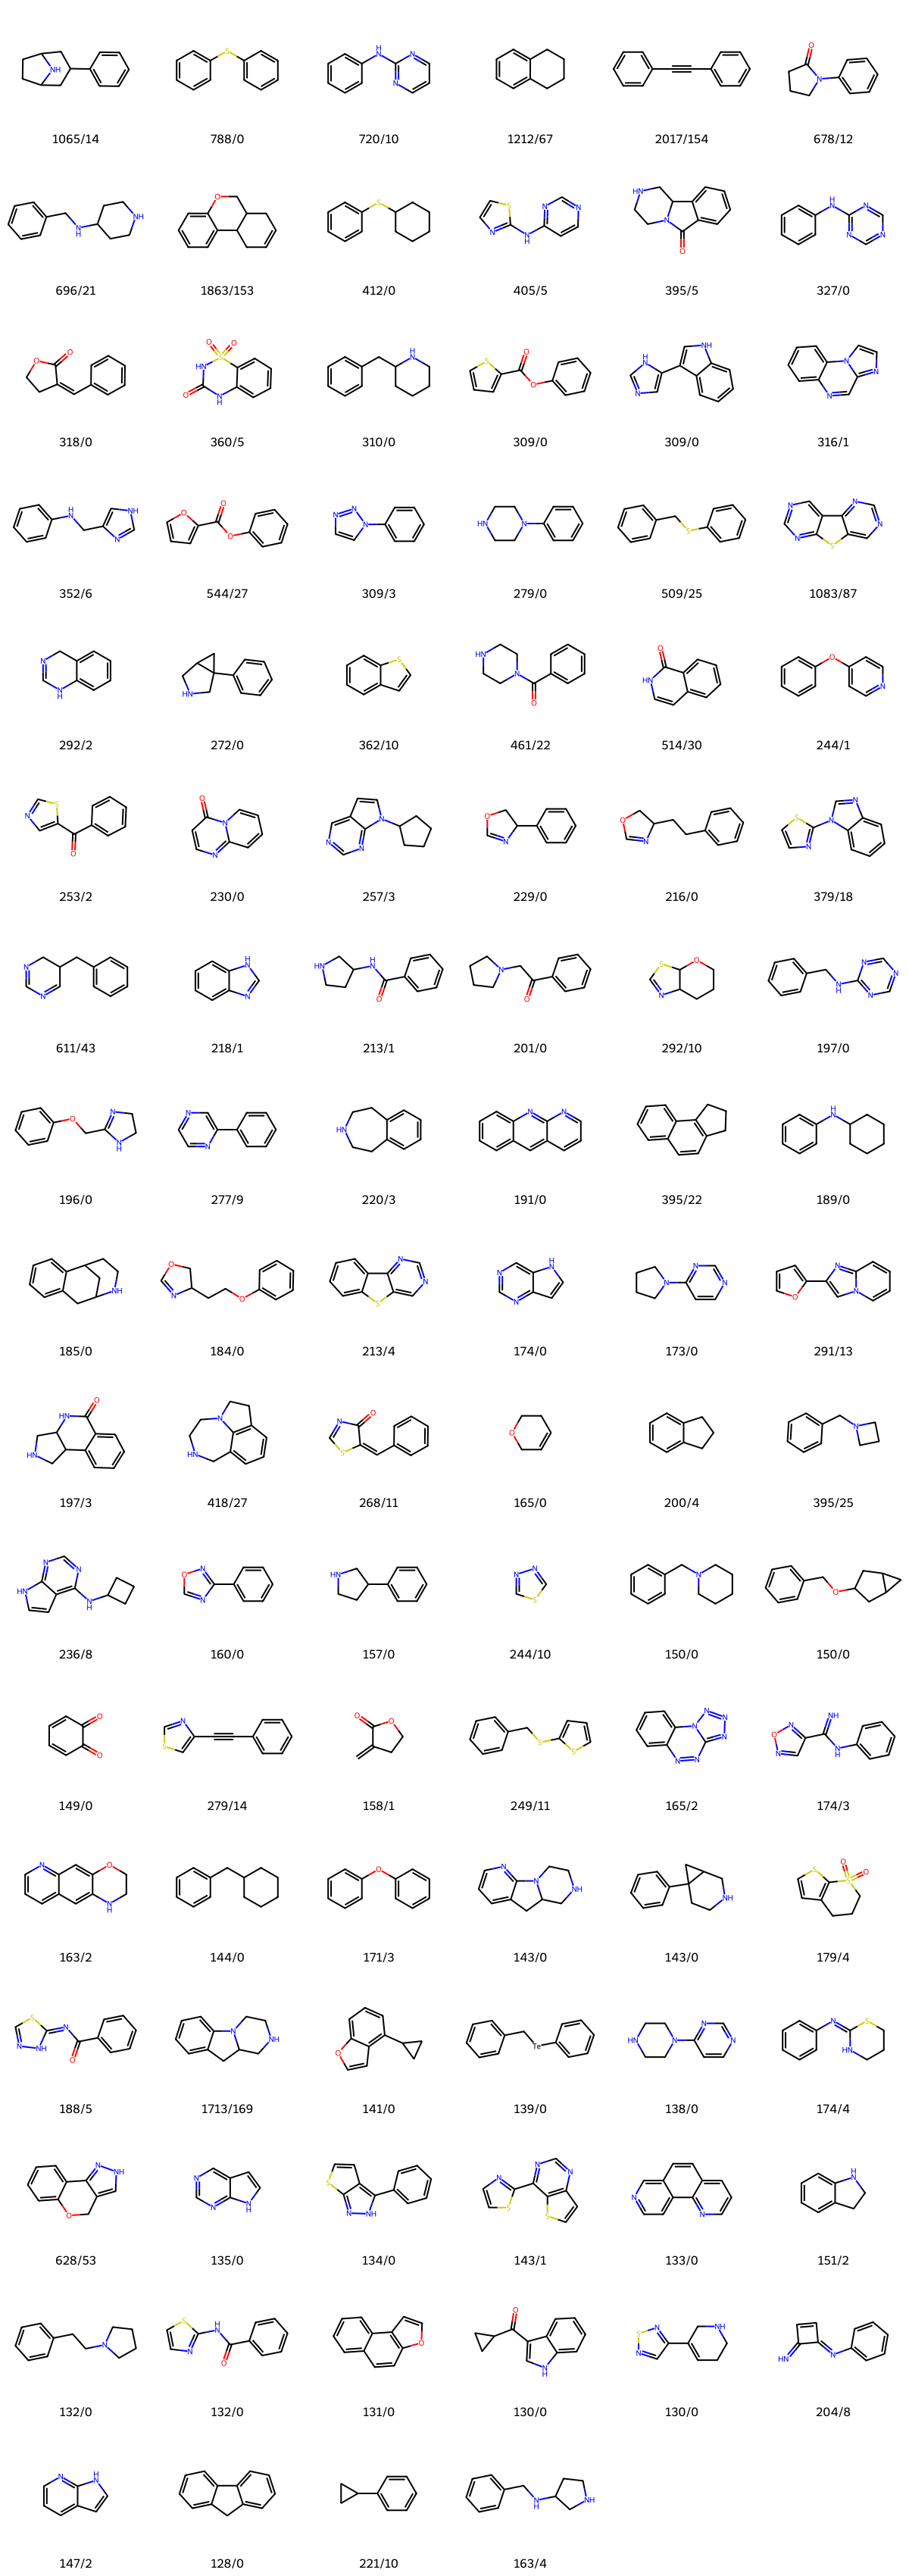

In [19]:
from rdkit.Chem import Draw

print('Sub 15 HA set')

Draw.MolsToGridImage(scaffolds.loc[scaffolds.N_HA < 15].iloc[:100].index.to_series().apply(Chem.MolFromSmiles).to_list(),
                     legends=scaffolds.iloc[:100].apply(lambda row: f'{row.active_count:.0f}/{row.inactive_count:.0f}', axis=1).to_list(),
                     molsPerRow=6, maxMols=100
                    )

In [40]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default='iframe'  # rendering issue on remote notebook
px.scatter(scaffolds, 'smoothed_ratio', 'Total',
           title='Bioactivity vs. abundance — Smoothing strength check', opacity=0.2,
           log_y=True,
           template='plotly_white', labels={'smoothed_ratio': f'Laplace smoothed ratio of bioactive/inactive (alpha={alpha:.1f})', 'Total': 'Total number of compounds with given scaffold'})